<h2><span style="color:#8e44ad"><span style="font-family:Georgia,serif">Customer Segmentation via K-Means & Hierarchical Clustering & DBSCAN </span></span></h2>
 
Customer segmentation is the process of dividing a customer base into smaller groups based on common characteristics or behaviors. This is often done as a way to better understand and target specific segments of a customer base, in order to tailor marketing efforts or product offerings to their specific needs and preferences.

Unsupervised learning is a type of machine learning that involves training a model to find patterns or relationships in data without the use of labeled examples or prior knowledge. It is often used for tasks such as clustering, where the goal is to group data points into clusters based on their similarity to one another. There are several unsupervised learning algorithms that can be used for customer segmentation, including:

1. K-means clustering: This algorithm divides the data into a specified number of clusters based on the distance between the data points and their respective cluster centroids.

2. Hierarchical clustering: This algorithm creates a hierarchy of clusters by repeatedly merging or splitting the data based on their similarity.

3. DBSCAN (Density-Based Spatial Clustering of Applications with Noise): This algorithm divides the data into clusters based on the density of the points and the distance between them.

<h2><span style="font-family:Georgia,serif">&nbsp;<span style="color:#8e44ad">Business Problem: Segmentation of a Customer Portfolio</span></span></h2>

FLO wants to segment its customers and determine marketing strategies according to these segments.
To this end, the behaviors of the customers will be defined and groups will be formed according to the clusters in these behaviors.

<h2><span style="color:#8e44ad"><span style="font-family:Georgia,serif">Dataset Story: Purchasing Behavior of FLO Customers</span></span></h2>

The dataset includes Flo's last purchases from OmniChannel (both online and offline shoppers) in 2020 - 2021. 12 Variables 19,945 Observations 2.7MB

* master_id: Unique client number
* order_channel: Which channel of the shopping platform is used (Android, ios, Desktop, Mobile)
* last_order_channel: The channel where the last purchase was made
* first_order_date: The date of the first purchase made by the customer
* last_order_date: The date of the customer's last purchase
* last_order_date_online: The date of the last purchase made by the customer on the online platform
* last_order_date_offline: The date of the last purchase made by the customer on the offline platform
* order_num_total_ever_online: The total number of purchases made by the customer on the online platform
* order_num_total_ever_offline: Total number of purchases made by the customer offline
* customer_value_total_ever_offline: The total price paid by the customer for offline purchases
* customer_value_total_ever_online: The total price paid by the customer for their online shopping
* interested_in_categories_12: List of categories the customer has purchased from in the last 12 months

# 1. Loading required libraries and data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans      # K-Means
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer     # Elbow method 
from scipy.cluster.hierarchy import linkage, dendrogram  # hierarchical clustering
from sklearn.preprocessing import StandardScaler    
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering     # hierarchical clustering

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
import warnings 
warnings.simplefilter(action='ignore', category=Warning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/flodata/flo_data_20k.csv


In [4]:
df = pd.read_csv('/kaggle/input/flodata/flo_data_20k.csv')

df['tenure'] = (pd.to_datetime('today') - pd.to_datetime(df['first_order_date'])).dt.days
df['recency'] = (pd.to_datetime('today') - pd.to_datetime(df['last_order_date'])).dt.days
df['frequency'] = df['order_num_total_ever_online'] + df['order_num_total_ever_offline']
df['monetary'] = df['customer_value_total_ever_online'] + df['customer_value_total_ever_offline']

df["order_num_total"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["customer_value_total"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]

# 2. Exploratory Data Analysis

In [12]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(19945, 18)
##################### Types #####################
master_id                             object
order_channel                         object
last_order_channel                    object
first_order_date                      object
last_order_date                       object
last_order_date_online                object
last_order_date_offline               object
order_num_total_ever_online          float64
order_num_total_ever_offline         float64
customer_value_total_ever_offline    float64
customer_value_total_ever_online     float64
interested_in_categories_12           object
tenure                                 int64
recency                                int64
frequency                            float64
monetary                             float64
order_num_total                      float64
customer_value_total                 float64
dtype: object
##################### Head #####################
               

In [16]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

In [20]:
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

In [26]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
Note: Categorical variables with numerical appearance are also included in categorical variables.

     parameters
     ------
         dataframe: dataframe
                 The dataframe from which variable names are to be retrieved
         cat_th: int, optional
                 class threshold for numeric but categorical variables
         car_th: int, optinal
                 class threshold for categorical but cardinal variables

     Returns
     ------
         cat_cols: list
                 Categorical variable list
         num_cols: list
                 Numeric variable list
         cat_but_car: list
                 Categorical view cardinal variable list

     Examples
     ------
         import seaborn as sns
         df = sns.load_dataset("iris")
         print(grab_col_names(df))


     notes
     ------
         cat_cols + num_cols + cat_but_car = total number of variables
         num_but_cat is inside cat_cols.
         The sum of the 3 returned lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car
     
    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
    print(cat_cols)
    print(num_cols)
    print(cat_but_car)

In [27]:
cat_cols

['order_channel', 'last_order_channel']

In [28]:
num_cols

['order_num_total_ever_online',
 'order_num_total_ever_offline',
 'customer_value_total_ever_offline',
 'customer_value_total_ever_online',
 'tenure',
 'recency',
 'frequency',
 'monetary',
 'order_num_total',
 'customer_value_total']

count    19945.000000
mean         3.110855
std          4.225647
min          1.000000
5%           1.000000
10%          1.000000
20%          1.000000
30%          1.000000
40%          1.000000
50%          2.000000
60%          2.000000
70%          3.000000
80%          4.000000
90%          7.000000
95%         10.000000
99%         20.000000
max        200.000000
Name: order_num_total_ever_online, dtype: float64


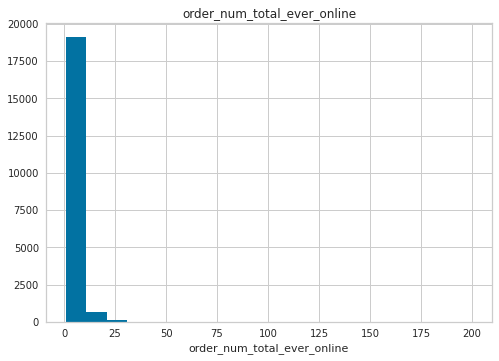

count    19945.000000
mean         1.913913
std          2.062880
min          1.000000
5%           1.000000
10%          1.000000
20%          1.000000
30%          1.000000
40%          1.000000
50%          1.000000
60%          2.000000
70%          2.000000
80%          3.000000
90%          4.000000
95%          4.000000
99%          7.000000
max        109.000000
Name: order_num_total_ever_offline, dtype: float64


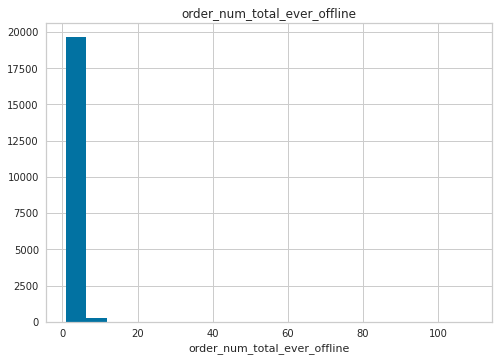

count    19945.000000
mean       253.922597
std        301.532853
min         10.000000
5%          39.990000
10%         59.990000
20%         89.980000
30%        110.480000
40%        140.230000
50%        179.980000
60%        220.860000
70%        281.868000
80%        365.058000
90%        519.950000
95%        694.222000
99%       1219.946800
max      18119.140000
Name: customer_value_total_ever_offline, dtype: float64


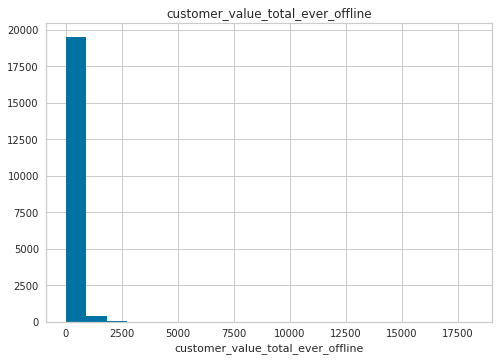

count    19945.000000
mean       497.321690
std        832.601886
min         12.990000
5%          63.990000
10%         84.990000
20%        125.990000
30%        173.970000
40%        219.990000
50%        286.460000
60%        371.944000
70%        491.526000
80%        690.868000
90%       1082.036000
95%       1556.726000
99%       3143.810400
max      45220.130000
Name: customer_value_total_ever_online, dtype: float64


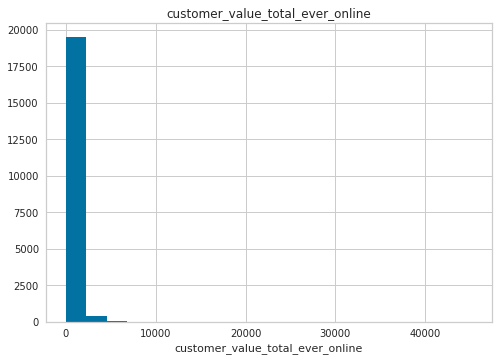

count    19945.000000
mean      1371.302833
std        523.396883
min        575.000000
5%         779.200000
10%        908.000000
20%       1048.000000
30%       1119.000000
40%       1170.000000
50%       1221.000000
60%       1300.000000
70%       1384.000000
80%       1537.200000
90%       2114.000000
95%       2644.000000
99%       3175.000000
max       3630.000000
Name: tenure, dtype: float64


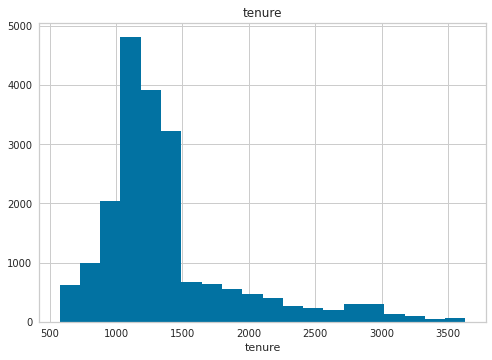

count    19945.000000
mean       704.458360
std        103.281149
min        572.000000
5%         579.000000
10%        586.000000
20%        603.000000
30%        626.000000
40%        653.000000
50%        681.000000
60%        715.000000
70%        756.000000
80%        802.000000
90%        878.000000
95%        905.000000
99%        930.000000
max        937.000000
Name: recency, dtype: float64


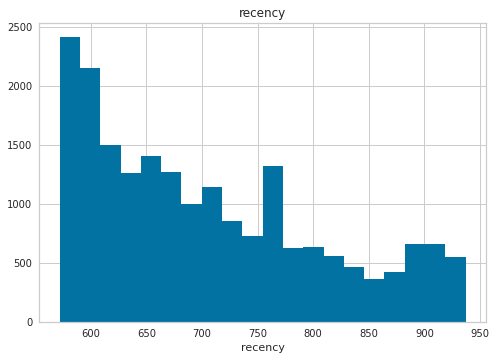

count    19945.000000
mean         5.024768
std          4.742707
min          2.000000
5%           2.000000
10%          2.000000
20%          2.000000
30%          3.000000
40%          3.000000
50%          4.000000
60%          4.000000
70%          5.000000
80%          7.000000
90%          9.000000
95%         12.000000
99%         22.000000
max        202.000000
Name: frequency, dtype: float64


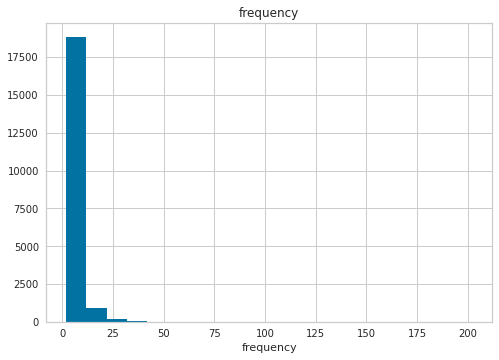

count    19945.000000
mean       751.244287
std        895.402173
min         44.980000
5%         175.480000
10%        224.970000
20%        302.188000
30%        378.888000
40%        455.826000
50%        545.270000
60%        660.380000
70%        803.706000
80%       1020.036000
90%       1429.938000
95%       1921.924000
99%       3606.355600
max      45905.100000
Name: monetary, dtype: float64


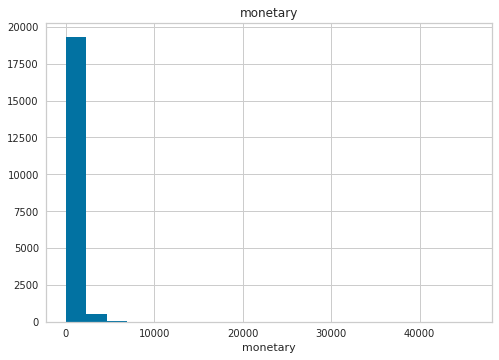

count    19945.000000
mean         5.024768
std          4.742707
min          2.000000
5%           2.000000
10%          2.000000
20%          2.000000
30%          3.000000
40%          3.000000
50%          4.000000
60%          4.000000
70%          5.000000
80%          7.000000
90%          9.000000
95%         12.000000
99%         22.000000
max        202.000000
Name: order_num_total, dtype: float64


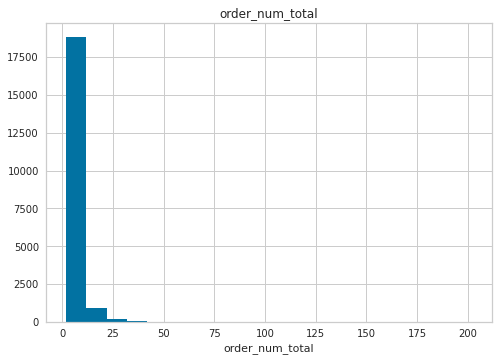

count    19945.000000
mean       751.244287
std        895.402173
min         44.980000
5%         175.480000
10%        224.970000
20%        302.188000
30%        378.888000
40%        455.826000
50%        545.270000
60%        660.380000
70%        803.706000
80%       1020.036000
90%       1429.938000
95%       1921.924000
99%       3606.355600
max      45905.100000
Name: customer_value_total, dtype: float64


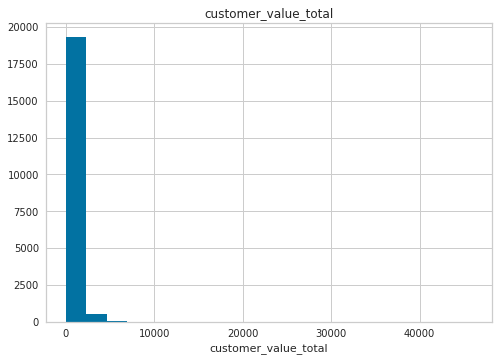

In [30]:
# Examination of numerical variables
df[num_cols].describe().T

for col in num_cols:
     num_summary(df, col, plot=True)

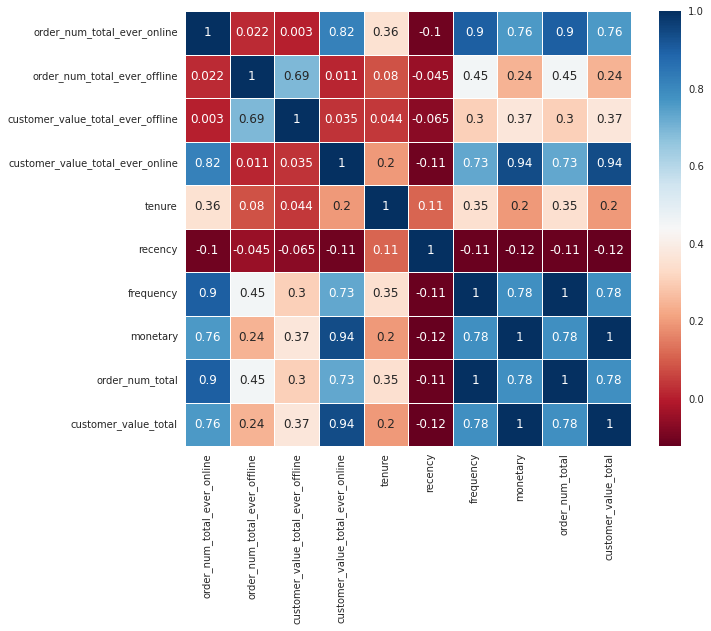

In [31]:
# Correlation of numerical variables with each other
correlation_matrix(df, num_cols)

# 3. Data Preprocessing & Feature Engineering

In [33]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]
for col in binary_cols:
    df = label_encoder(df, col)

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in df.columns if
            25 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols)
cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [34]:
cat_cols

['order_channel_Desktop',
 'order_channel_Ios App',
 'order_channel_Mobile',
 'last_order_channel_Desktop',
 'last_order_channel_Ios App',
 'last_order_channel_Mobile',
 'last_order_channel_Offline']

In [35]:
num_cols

['order_num_total_ever_online',
 'order_num_total_ever_offline',
 'customer_value_total_ever_offline',
 'customer_value_total_ever_online',
 'tenure',
 'recency',
 'frequency',
 'monetary',
 'order_num_total',
 'customer_value_total']

In [36]:
df.head()

,master_id,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,tenure,recency,frequency,monetary,order_num_total,customer_value_total,order_channel_Desktop,order_channel_Ios App,order_channel_Mobile,last_order_channel_Desktop,last_order_channel_Ios App,last_order_channel_Mobile,last_order_channel_Offline
0,cc294636-19f0-11eb-8d74-000d3a38a36f,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN],784,665,5.0,939.37,5.0,939.37,0,0,0,0,0,0,1
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2144,675,21.0,2013.55,21.0,2013.55,0,0,0,0,0,1,0
2,69b69676-1a40-11ea-941b-000d3a38a36f,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]",1122,756,5.0,585.32,5.0,585.32,0,0,0,0,0,0,0
3,1854e56c-491f-11eb-806e-000d3a38a36f,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]",716,705,2.0,121.97,2.0,121.97,0,0,0,0,0,0,0
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR],1238,656,2.0,209.98,2.0,209.98,1,0,0,1,0,0,0


In [37]:
df.shape

(19945, 23)

# 4. Customer Segmentation with K-Means

K-Means is a clustering algorithm used to divide a dataset into clusters. This algorithm creates clusters using the coordinates of the points in the dataset. Therefore, the K-Means algorithm can only be applied for numerical variables. The K-Means algorithm determines a center point to divide the dataset into its clusters. These center points are the average of the coordinates of the points in the dataset. The K-Means algorithm assigns each point to the nearest centre.

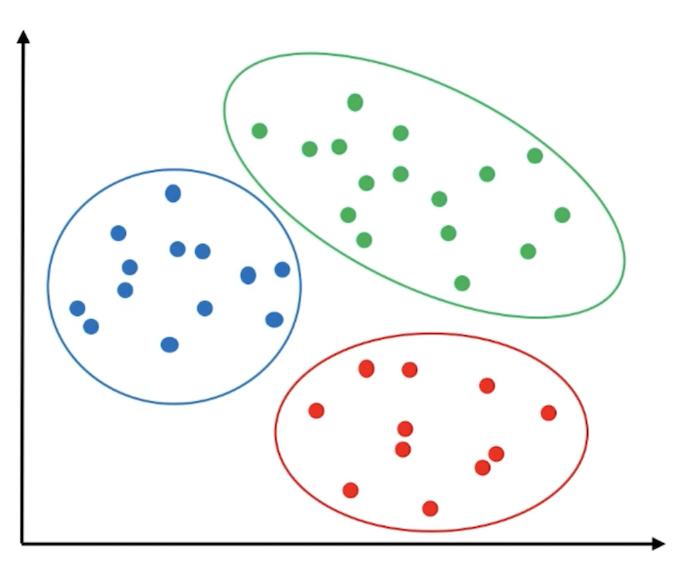

In [38]:
sc = StandardScaler()
X = sc.fit_transform(df[num_cols])
X = pd.DataFrame(X, columns=num_cols)
X.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,tenure,recency,frequency,monetary,order_num_total,customer_value_total
0,0.210422,-0.443039,-0.377854,0.362797,-1.122127,-0.382058,-0.005222,0.210107,-0.005222,0.210107
1,3.760263,0.041732,-0.311591,1.628981,1.476349,-0.285232,3.368463,1.409799,3.368463,1.409799
2,-0.026234,0.041732,-0.212097,-0.122477,-0.476329,0.499055,-0.005222,-0.185312,-0.005222,-0.185312
3,-0.499547,-0.443039,-0.709501,-0.498860,-1.252050,0.005244,-0.637788,-0.702802,-0.637788,-0.702802
4,-0.499547,-0.443039,-0.676337,-0.405164,-0.254694,-0.469201,-0.637788,-0.604508,-0.637788,-0.604508


For the K-Means algorithm to work, it is necessary to determine the optimum clusters. The Elbow method can be used for this. For the Elbow method, the WCSS values of the clusters must be calculated. WCSS values decrease with increasing number of clusters. Looking at the graph of these values, the decrease slows down after a point. After this point, increasing the number of clusters will not work. This point is called the Elbow point.

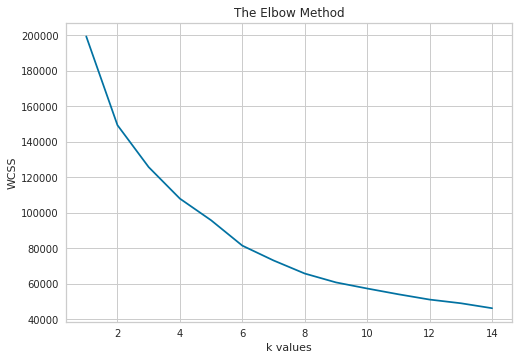

In [39]:
wcss = []  # We created a list to hold WCSS values.
for k in range(1, 15):  # We looped the numbers from 1 to 15.
    kmeans = KMeans(n_clusters=k).fit(X)  # We ran the K-Means algorithm.
    wcss.append(kmeans.inertia_)  # We added the WCSS values to the wcss list.

plt.plot(range(1, 15), wcss, 'bx-')  # We plotted the WCSS values.
plt.xlabel('k values')
plt.ylabel('WCSS')  
plt.title('The Elbow Method')  
plt.show()  

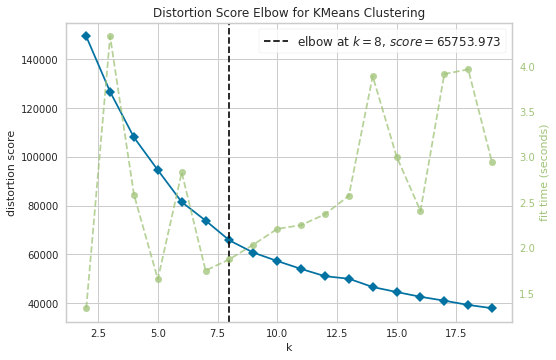

8

In [40]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(X)
elbow.show(block=True)

elbow.elbow_value_

In [41]:
kmeans = KMeans(n_clusters=elbow.elbow_value_, init='k-means++').fit(X)
kmeans.cluster_centers_  # Indicates the centers of clusters.

array([[ 6.26178401e-02, -4.30300245e-02, -6.10361943e-02,
        -1.25835858e-01,  2.28888994e+00,  2.95089031e-01,
         3.70748392e-02, -1.37564543e-01,  3.70748392e-02,
        -1.37564543e-01],
       [ 2.03261890e+01, -1.66026739e-01,  8.60791003e-01,
         3.23327984e+01,  1.63056540e+00, -8.91083198e-01,
         1.80379698e+01,  3.03549695e+01,  1.80379698e+01,
         3.03549695e+01],
       [-3.13802902e-01, -1.96897055e-01, -2.31818346e-01,
        -2.56219330e-01, -2.49870088e-01,  1.17024520e+00,
        -3.65233467e-01, -3.16315453e-01, -3.65233467e-01,
        -3.16315453e-01],
       [ 1.22009842e+00, -5.53199095e-02, -1.01334006e-01,
         1.05533475e+00,  4.29532648e-01, -3.39807819e-01,
         1.06301883e+00,  9.47192438e-01,  1.06301883e+00,
         9.47192438e-01],
       [ 4.18544165e+00,  2.98790269e-01,  2.33612864e-01,
         3.37199349e+00,  1.45905619e+00, -4.12277496e-01,
         3.85909721e+00,  3.21416473e+00,  3.85909721e+00,
         3.

In [42]:
kmeans.n_clusters  # Indicates the number of clusters.

8

In [43]:
kmeans.labels_

array([6, 4, 2, ..., 6, 7, 2], dtype=int32)

In [44]:
kmeans.inertia_  # Displays the WCSS value.

65766.97770803791

In [45]:
kmeans.get_params()  # With get_params() we can see the parameters of the kmeans model.

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 8,
 'n_init': 10,
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [46]:
X[0:5]

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,tenure,recency,frequency,monetary,order_num_total,customer_value_total
0,0.210422,-0.443039,-0.377854,0.362797,-1.122127,-0.382058,-0.005222,0.210107,-0.005222,0.210107
1,3.760263,0.041732,-0.311591,1.628981,1.476349,-0.285232,3.368463,1.409799,3.368463,1.409799
2,-0.026234,0.041732,-0.212097,-0.122477,-0.476329,0.499055,-0.005222,-0.185312,-0.005222,-0.185312
3,-0.499547,-0.443039,-0.709501,-0.498860,-1.252050,0.005244,-0.637788,-0.702802,-0.637788,-0.702802
4,-0.499547,-0.443039,-0.676337,-0.405164,-0.254694,-0.469201,-0.637788,-0.604508,-0.637788,-0.604508


**Build your model and segment your customers.**

In [47]:
clusters_kmeans = kmeans.labels_    # Indicates which observation the clusters belong to.
X["cluster"] = clusters_kmeans   # We added a variable named cluster_no to X.
X.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,tenure,recency,frequency,monetary,order_num_total,customer_value_total,cluster
0,0.210422,-0.443039,-0.377854,0.362797,-1.122127,-0.382058,-0.005222,0.210107,-0.005222,0.210107,6
1,3.760263,0.041732,-0.311591,1.628981,1.476349,-0.285232,3.368463,1.409799,3.368463,1.409799,4
2,-0.026234,0.041732,-0.212097,-0.122477,-0.476329,0.499055,-0.005222,-0.185312,-0.005222,-0.185312,2
3,-0.499547,-0.443039,-0.709501,-0.498860,-1.252050,0.005244,-0.637788,-0.702802,-0.637788,-0.702802,6
4,-0.499547,-0.443039,-0.676337,-0.405164,-0.254694,-0.469201,-0.637788,-0.604508,-0.637788,-0.604508,6


In [48]:
X.groupby('cluster').agg(['mean', 'median', 'count', 'std'])
X.groupby('cluster').agg(['mean', 'median', 'count', 'std']).T

cluster                                             0          1            2            3           4          5            6            7
order_num_total_ever_online       mean       0.062618  20.326189    -0.313883     1.220098    4.185442   0.007574    -0.279021    -0.145600
                                  median    -0.026234  15.593067    -0.499547     1.157046    3.760263  -0.262891    -0.499547    -0.262891
                                  count   1670.000000   7.000000  5481.000000  1978.000000  413.000000  14.000000  8671.000000  1711.000000
                                  std        0.520116  14.238753     0.271877     0.677370    1.993585   0.770257     0.290063     0.390577
order_num_total_ever_offline      mean      -0.043030  -0.166027    -0.196894    -0.055320    0.298790  24.453429    -0.186425     1.409915
                                  median    -0.443039  -0.443039    -0.443039    -0.443039    0.041732  21.371668    -0.443039     1.011275
                                  count   1670.000000   7.000000  5481.000000  1978.000000  413.000000  14.000000  8671.000000  1711.000000
                                  std        0.537647   0.549679     0.375155     0.500423    1.060272  13.250940     0.367708     1.066084
customer_value_total_ever_offline mean      -0.061036   0.860791    -0.231560    -0.101334    0.233613  18.025153    -0.196165     1.705226
                                  median    -0.212047   0.945252    -0.344723    -0.245229   -0.155684  11.986747    -0.311525     1.396292
                                  count   1670.000000   7.000000  5481.000000  1978.000000  413.000000  14.000000  8671.000000  1711.000000
                                  std        0.584047   1.513316     0.434323     0.564651    1.237376  14.075985     0.435397     1.242997
customer_value_total_ever_online  mean      -0.125836  32.332798    -0.256196     1.055335    3.371993   0.294731    -0.223213    -0.093925
                                  median    -0.195635  36.262115    -0.337903     0.934177    2.885255  -0.350629    -0.306795    -0.205796
                                  count   1670.000000   7.000000  5481.000000  1978.000000  413.000000  14.000000  8671.000000  1711.000000
                                  std        0.345176  14.545352     0.268640     0.621357    1.787356   1.289366     0.280899     0.378331
tenure                            mean       2.288890   1.630565    -0.249756     0.429533    1.459056   0.021530    -0.443263    -0.043206
                                  median     2.275954   1.302481    -0.321567     0.068205    1.430494   0.060562    -0.426652    -0.182090
                                  count   1670.000000   7.000000  5481.000000  1978.000000  413.000000  14.000000  8671.000000  1711.000000
                                  std        0.821748   2.274596     0.461947     1.041752    1.333258   0.561630     0.473793     0.652742
recency                           mean       0.295089  -0.891083     1.170910    -0.339808   -0.412277   0.188521    -0.640411    -0.298972
                                  median     0.179530  -0.992058     1.070325    -0.575709   -0.711264  -0.420788    -0.701582    -0.498248
                                  count   1670.000000   7.000000  5481.000000  1978.000000  413.000000  14.000000  8671.000000  1711.000000
                                  std        0.993925   0.267448     0.614808     0.839896    0.835591   1.119900     0.449556     0.801961
frequency                         mean       0.037075  18.037970    -0.365304     1.063019    3.859097  10.642972    -0.329688     0.483528
                                  median    -0.005222  13.700374    -0.426933     0.943627    3.368463   9.166985    -0.426933     0.416488
                                  count   1670.000000   7.000000  5481.000000  1978.000000  413.000000  14.000000  8671.000000  1711.000000
                                  std        0.491644  12.713170     0.284633   

In [49]:
X['cluster'] = X['cluster'] + 1
X.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,tenure,recency,frequency,monetary,order_num_total,customer_value_total,cluster
0,0.210422,-0.443039,-0.377854,0.362797,-1.122127,-0.382058,-0.005222,0.210107,-0.005222,0.210107,7
1,3.760263,0.041732,-0.311591,1.628981,1.476349,-0.285232,3.368463,1.409799,3.368463,1.409799,5
2,-0.026234,0.041732,-0.212097,-0.122477,-0.476329,0.499055,-0.005222,-0.185312,-0.005222,-0.185312,3
3,-0.499547,-0.443039,-0.709501,-0.498860,-1.252050,0.005244,-0.637788,-0.702802,-0.637788,-0.702802,7
4,-0.499547,-0.443039,-0.676337,-0.405164,-0.254694,-0.469201,-0.637788,-0.604508,-0.637788,-0.604508,7


In [50]:
X["cluster"].value_counts()                 # It shows the number of observations belonging to each cluster.
X["cluster"].value_counts() / len(X) * 100

7    43.474555
3    27.480572
4     9.917272
8     8.578591
1     8.373026
5     2.070694
6     0.070193
2     0.035097
Name: cluster, dtype: float64

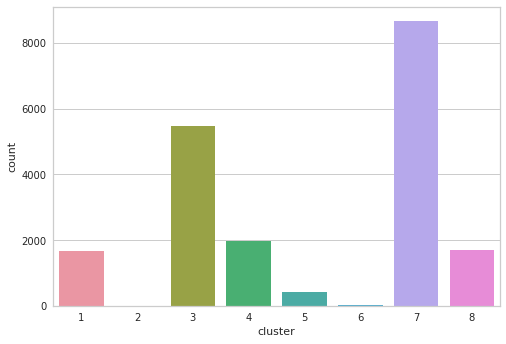

In [51]:
sns.countplot(x='cluster', data=X)
plt.show()

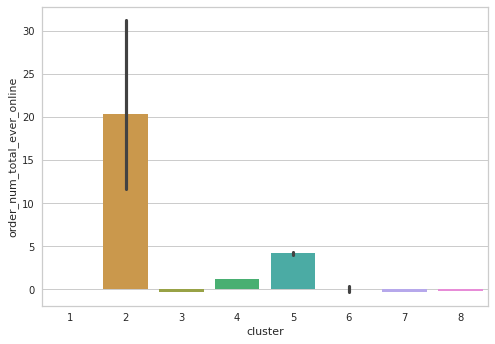

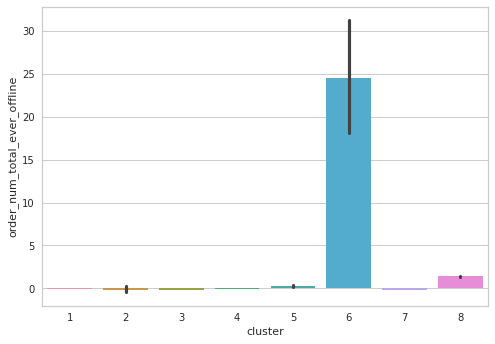

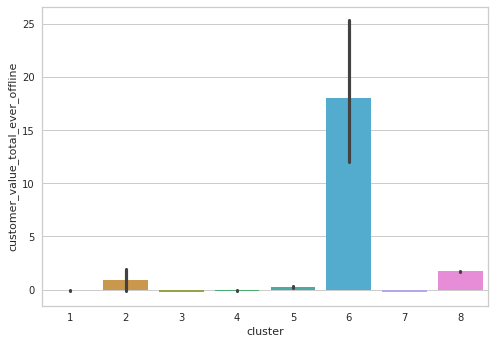

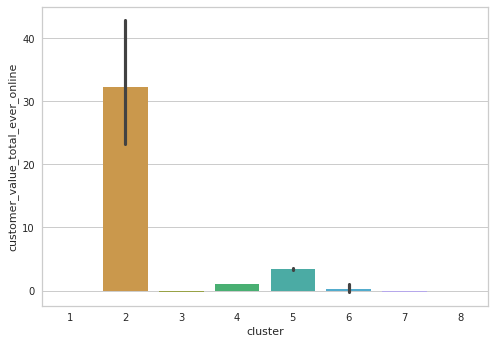

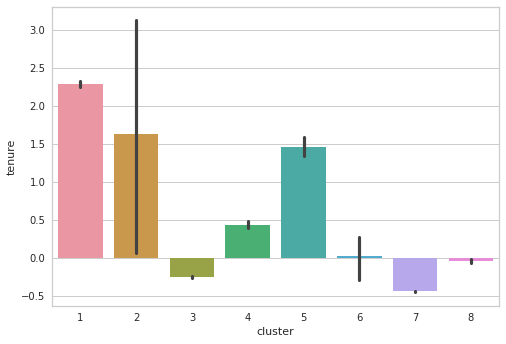

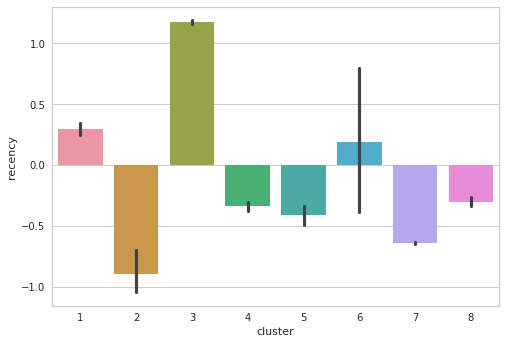

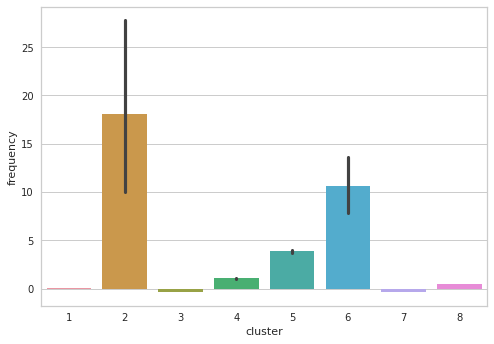

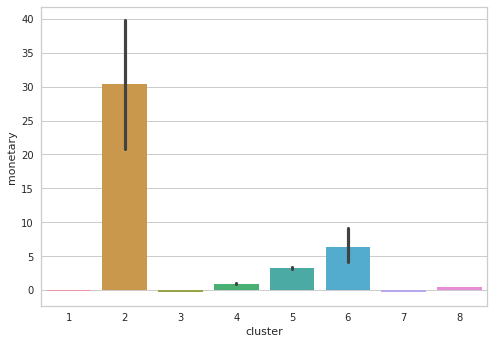

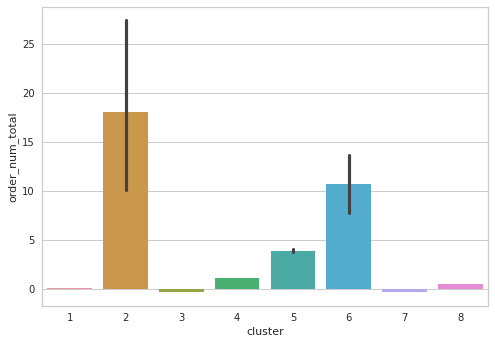

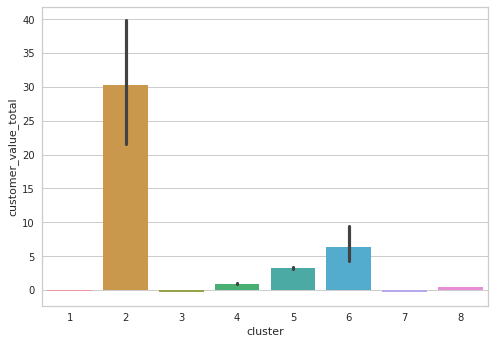

In [52]:
for i in num_cols:
    sns.barplot(x='cluster', y=i, data=X)
    plt.show()

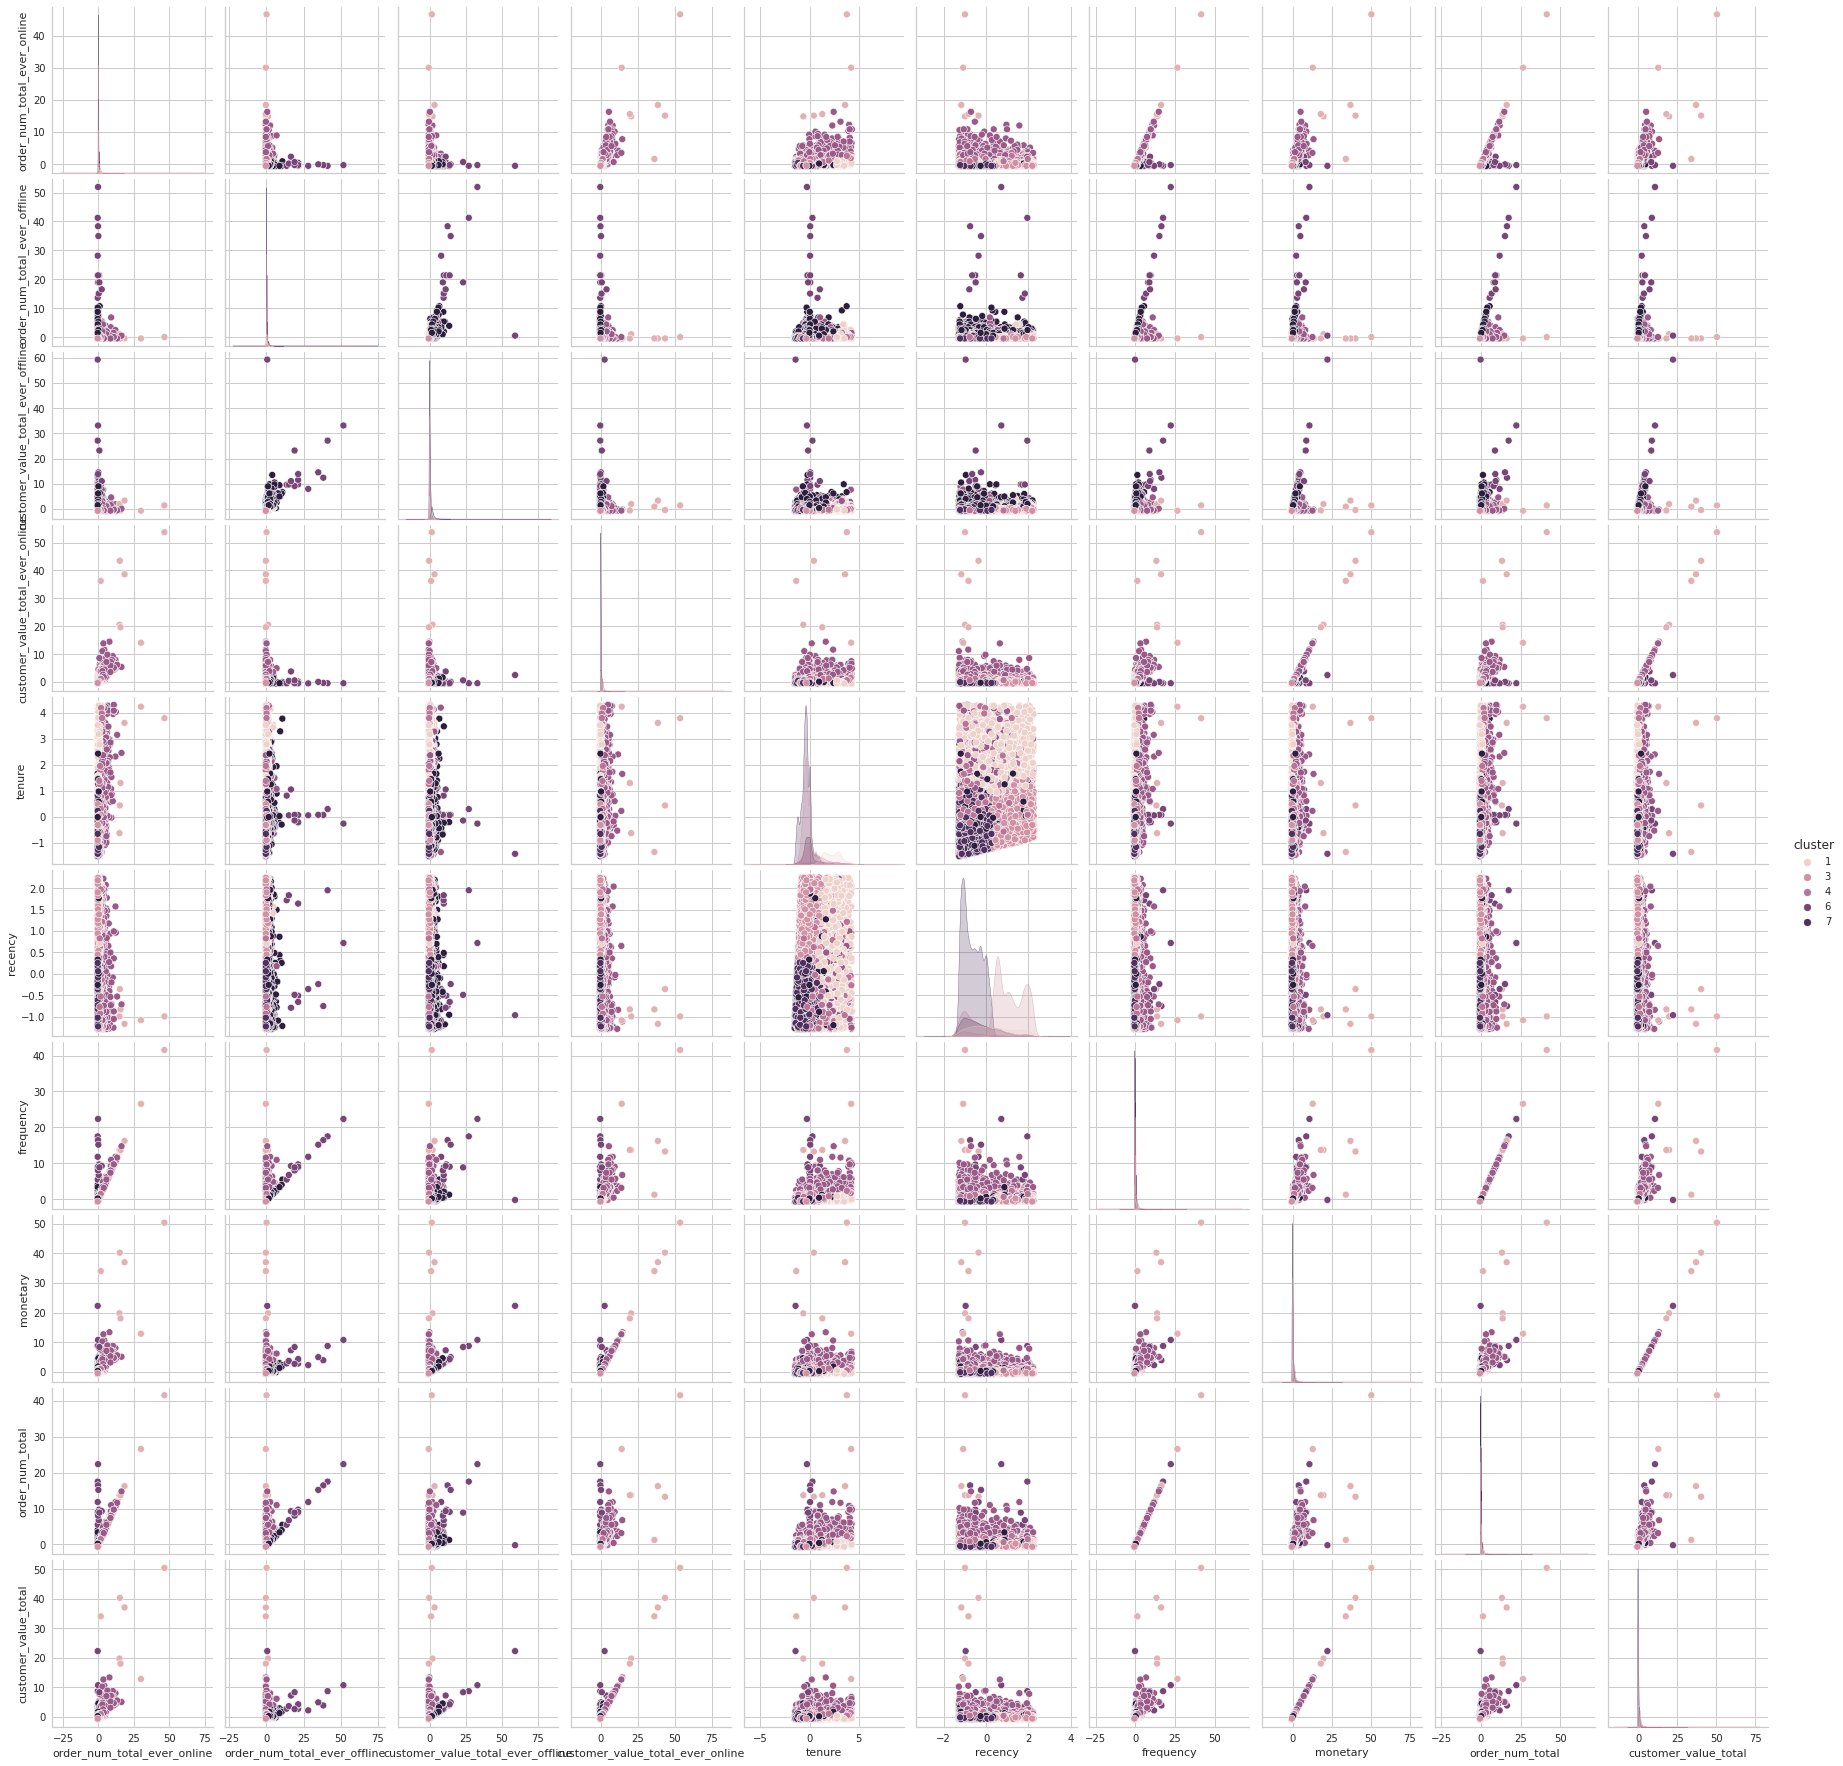

In [53]:
sns.pairplot(X, hue='cluster')
plt.show()

# 5. Customer Segmentation with Hierarchical Clustering

**The Hierarchical Clustering (HC) method** is a clustering method used to separate data points into groups with similar characteristics. This method is used to group data points about each other. Each of these groups is called a cluster.

The HC method is also called the link matrix method. This method is used to group data points according to their degree of connectivity to each other. This method creates a connectivity matrix to measure the degrees of relationship between data points. This matrix shows the degrees of connectivity between the data points and clusters the data points according to these degrees.

The connectivity matrix method clusters data points according to their degree of similarity and is used to measure the degree of association between data points. This method creates cluster centers according to the similarity degrees of the data points and places the data points in the clusters closest to these cluster centers. The connectivity matrix method is used to best group the data points and this method is used to measure the degrees of relationship between the data points. The differences between these methods are how they place the data points into clusters.

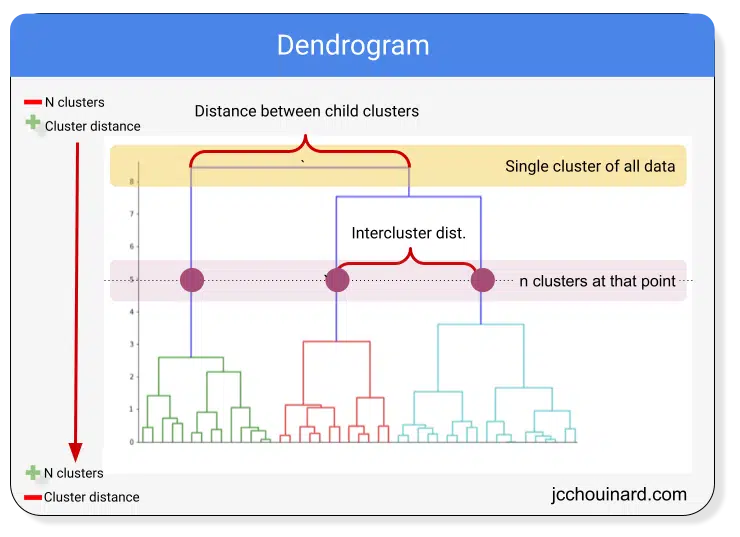

In this snippet, a link matrix is created that measures the degree of similarity of data points using the linkage() function of the scipy library. Then, using this link matrix, a dendogram is created with the HC method using the dendrogram() function of the scipy library. This dendogram is displayed using the show() function of the matplotlib library. In this snippet, the method parameter is specified as 'ward', so the hc_ward method is used as the HC method. This parameter value can take different values such as 'single', 'complete' or 'average' and according to these values, a dendogram can be obtained by applying the HC method with different methods.

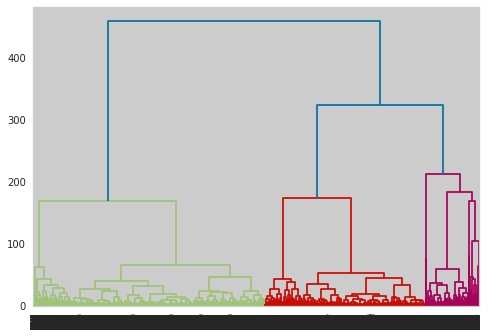

In [70]:
linkage_matrix = linkage(X, method='ward')

# Create the dendrogram
dend = dendrogram(linkage_matrix)

# Show the dendrogram
plt.show()

In [54]:
hc_average = linkage(X, "average")  # We created a connection matrix with the average method.
hc_ward = linkage(X, "ward")  # We created a connection matrix with the ward method.
hc_complete = linkage(X, "complete")  # We created a connection matrix with the complete method.
hc_single = linkage(X, "single")  # We created a connection matrix with the single method.
hc_centroid = linkage(X, "centroid")  # We created a connection matrix with the centroid method.

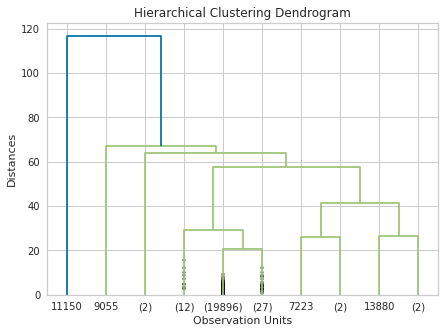

In [64]:
plt.figure(figsize=(7, 5))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Observation Units")
plt.ylabel("Distances")
dendrogram(hc_average,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.show()

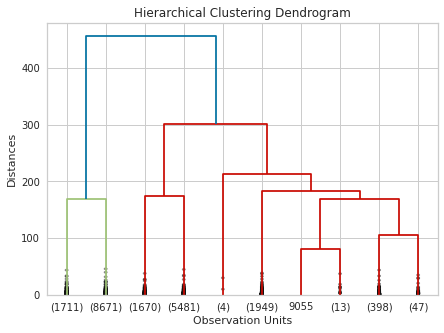

In [63]:
plt.figure(figsize=(7, 5))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Observation Units")
plt.ylabel("Distances")
dendrogram(hc_ward,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.show()

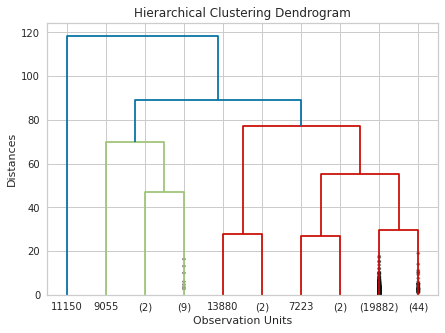

In [62]:
plt.figure(figsize=(7, 5))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Observation Units")
plt.ylabel("Distances")
dendrogram(hc_complete,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.show()

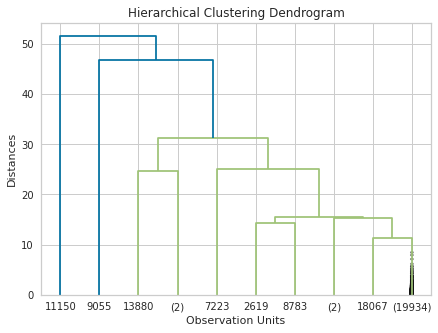

In [59]:
plt.figure(figsize=(7, 5))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Observation Units")
plt.ylabel("Distances")
dendrogram(hc_single,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.show()

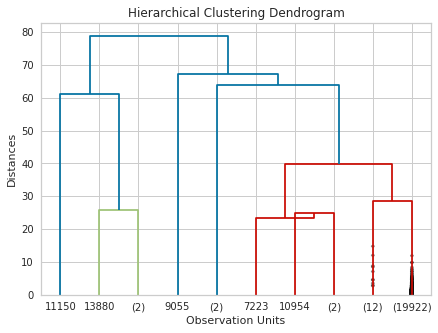

In [61]:
plt.figure(figsize=(7, 5))
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Observation Units")
plt.ylabel("Distances")
dendrogram(hc_centroid,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.show()

We are using the *AgglomerativeClustering* class from scikit-learn to perform hierarchical clustering on a dataset X. We are setting the number of clusters to 3 and using the Euclidean distance and the Ward linkage method for clustering.

The *fit_predict method* fits the model to the data and returns the cluster labels for each sample in the dataset. The cluster labels are stored in the clusters_hc array.

After running this code, we can use the *clusters_hc* array to see the cluster labels for each sample in the dataset. For example, if the first sample has a cluster label of 0, it belongs to the first cluster. If the second sample has a cluster label of 1, it belongs to the second cluster, and so on.

In [65]:
hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
clusters_hc = hc.fit_predict(X)
clusters_hc

X['cluster_hc'] = clusters_hc
X['cluster_hc'] = X['cluster_hc'] + 1
X.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,tenure,recency,frequency,monetary,order_num_total,customer_value_total,cluster,cluster_hc
0,0.210422,-0.443039,-0.377854,0.362797,-1.122127,-0.382058,-0.005222,0.210107,-0.005222,0.210107,7,2
1,3.760263,0.041732,-0.311591,1.628981,1.476349,-0.285232,3.368463,1.409799,3.368463,1.409799,5,1
2,-0.026234,0.041732,-0.212097,-0.122477,-0.476329,0.499055,-0.005222,-0.185312,-0.005222,-0.185312,3,3
3,-0.499547,-0.443039,-0.709501,-0.498860,-1.252050,0.005244,-0.637788,-0.702802,-0.637788,-0.702802,7,2
4,-0.499547,-0.443039,-0.676337,-0.405164,-0.254694,-0.469201,-0.637788,-0.604508,-0.637788,-0.604508,7,2


In [66]:
X.groupby('cluster_hc').agg(['mean', 'median', 'count', 'std'])
X.groupby('cluster_hc').agg(['mean', 'median', 'count', 'std']).T

cluster_hc                                          1             2            3
order_num_total_ever_online       mean       1.776257     -0.257032    -0.225958
                                  median     1.157046     -0.262891    -0.262891
                                  count   2412.000000  10382.000000  7151.000000
                                  std        1.956617      0.312807     0.381020
order_num_total_ever_offline      mean       0.147249      0.076659    -0.160962
                                  median     0.041732     -0.443039    -0.443039
                                  count   2412.000000  10382.000000  7151.000000
                                  std        2.193945      0.806802     0.423771
customer_value_total_ever_offline mean       0.064022      0.117192    -0.191737
                                  median    -0.225827     -0.185764    -0.324857
                                  count   2412.000000  10382.000000  7151.000000
                                  std        1.870713      0.954202     0.478965
customer_value_total_ever_online  mean       1.538367     -0.201906    -0.225752
                                  median     1.089694     -0.291097    -0.318169
                                  count   2412.000000  10382.000000  7151.000000
                                  std        2.219808      0.302948     0.293540
tenure                            mean       0.606932     -0.377331     0.343104
                                  median     0.236341     -0.386529    -0.187822
                                  count   2412.000000  10382.000000  7151.000000
                                  std        1.167673      0.528864     1.214462
recency                           mean      -0.350750     -0.584141     0.966376
                                  median    -0.604756     -0.662852     0.954135
                                  count   2412.000000  10382.000000  7151.000000
                                  std        0.841415      0.539239     0.810939
frequency                         mean       1.646652     -0.195667    -0.271335
                                  median     1.049054     -0.216078    -0.426933
                                  count   2412.000000  10382.000000  7151.000000
                                  std        1.952351      0.464148     0.384058
monetary                          mean       1.452031     -0.148280    -0.274488
                                  median     1.002782     -0.254344    -0.335907
                                  count   2412.000000  10382.000000  7151.000000
                                  std        2.166672      0.448052     0.310684
order_num_total                   mean       1.646652     -0.195667    -0.271335
                                  median     1.049054     -0.216078    -0.426933
                                  count   2412.000000  10382.000000  7151.000000
                                  std        1.952351      0.464148     0.384058
customer_value_total              mean       1.452031     -0.148280    -0.274488
                                  median     1.002782     -0.254344    -0.335907
                                  count   2412.000000  10382.000000  7151.000000
                                  std        2.166672      0.448052     0.310684
cluster                           mean       4.177032      7.164804     2.532932
                                  median     4.000000      7.000000     3.000000
                                  count   2412.000000  10382.000000  7151.000000
                                  std        0.418073      0.371022     0.846217

In [68]:
X["cluster_hc"].value_counts()                 # It shows the number of observations belonging to each cluster.
X["cluster_hc"].value_counts() / len(X) * 100

2    52.053146
3    35.853597
1    12.093256
Name: cluster_hc, dtype: float64

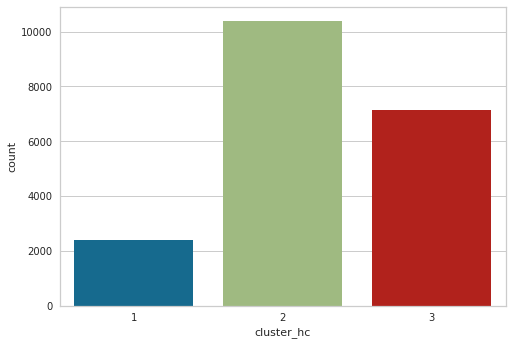

In [71]:
sns.countplot(x='cluster_hc', data=X)
plt.show()

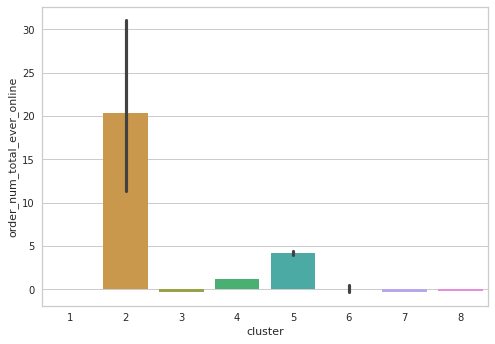

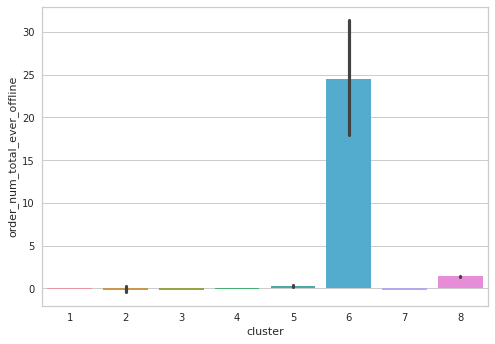

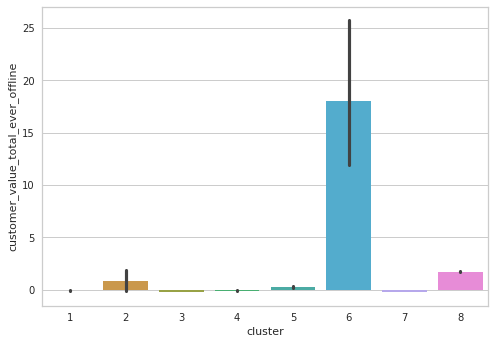

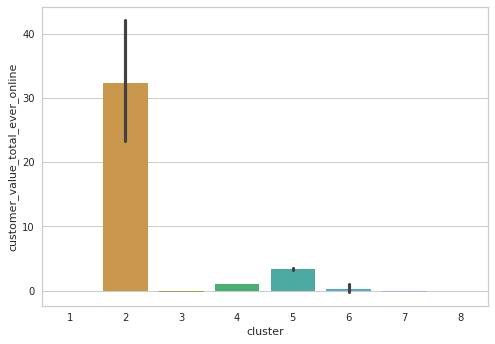

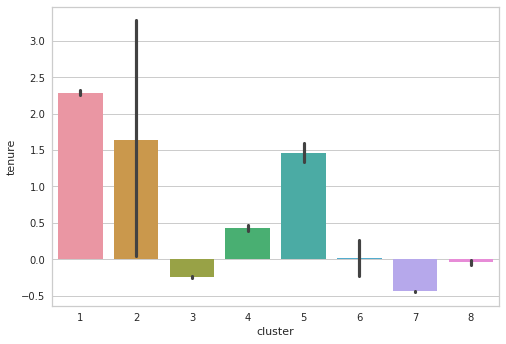

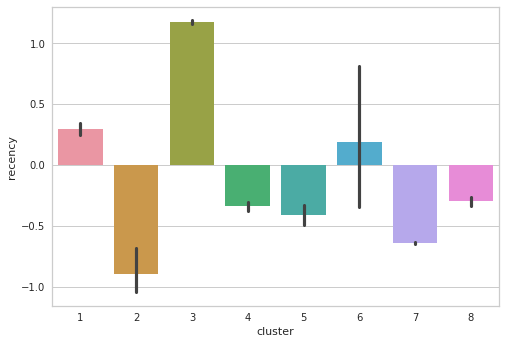

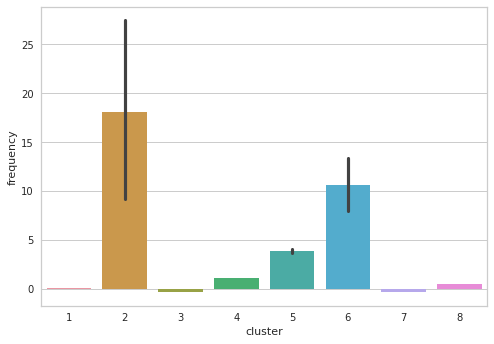

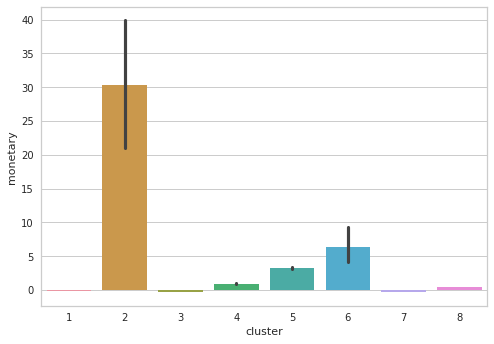

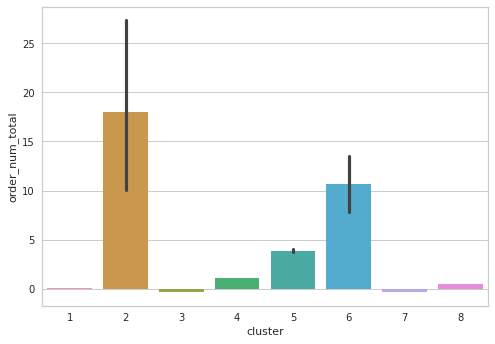

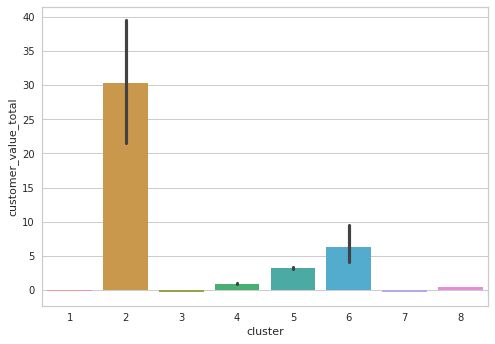

In [72]:
for i in num_cols:
    sns.barplot(x='cluster', y=i, data=X)
    plt.show()

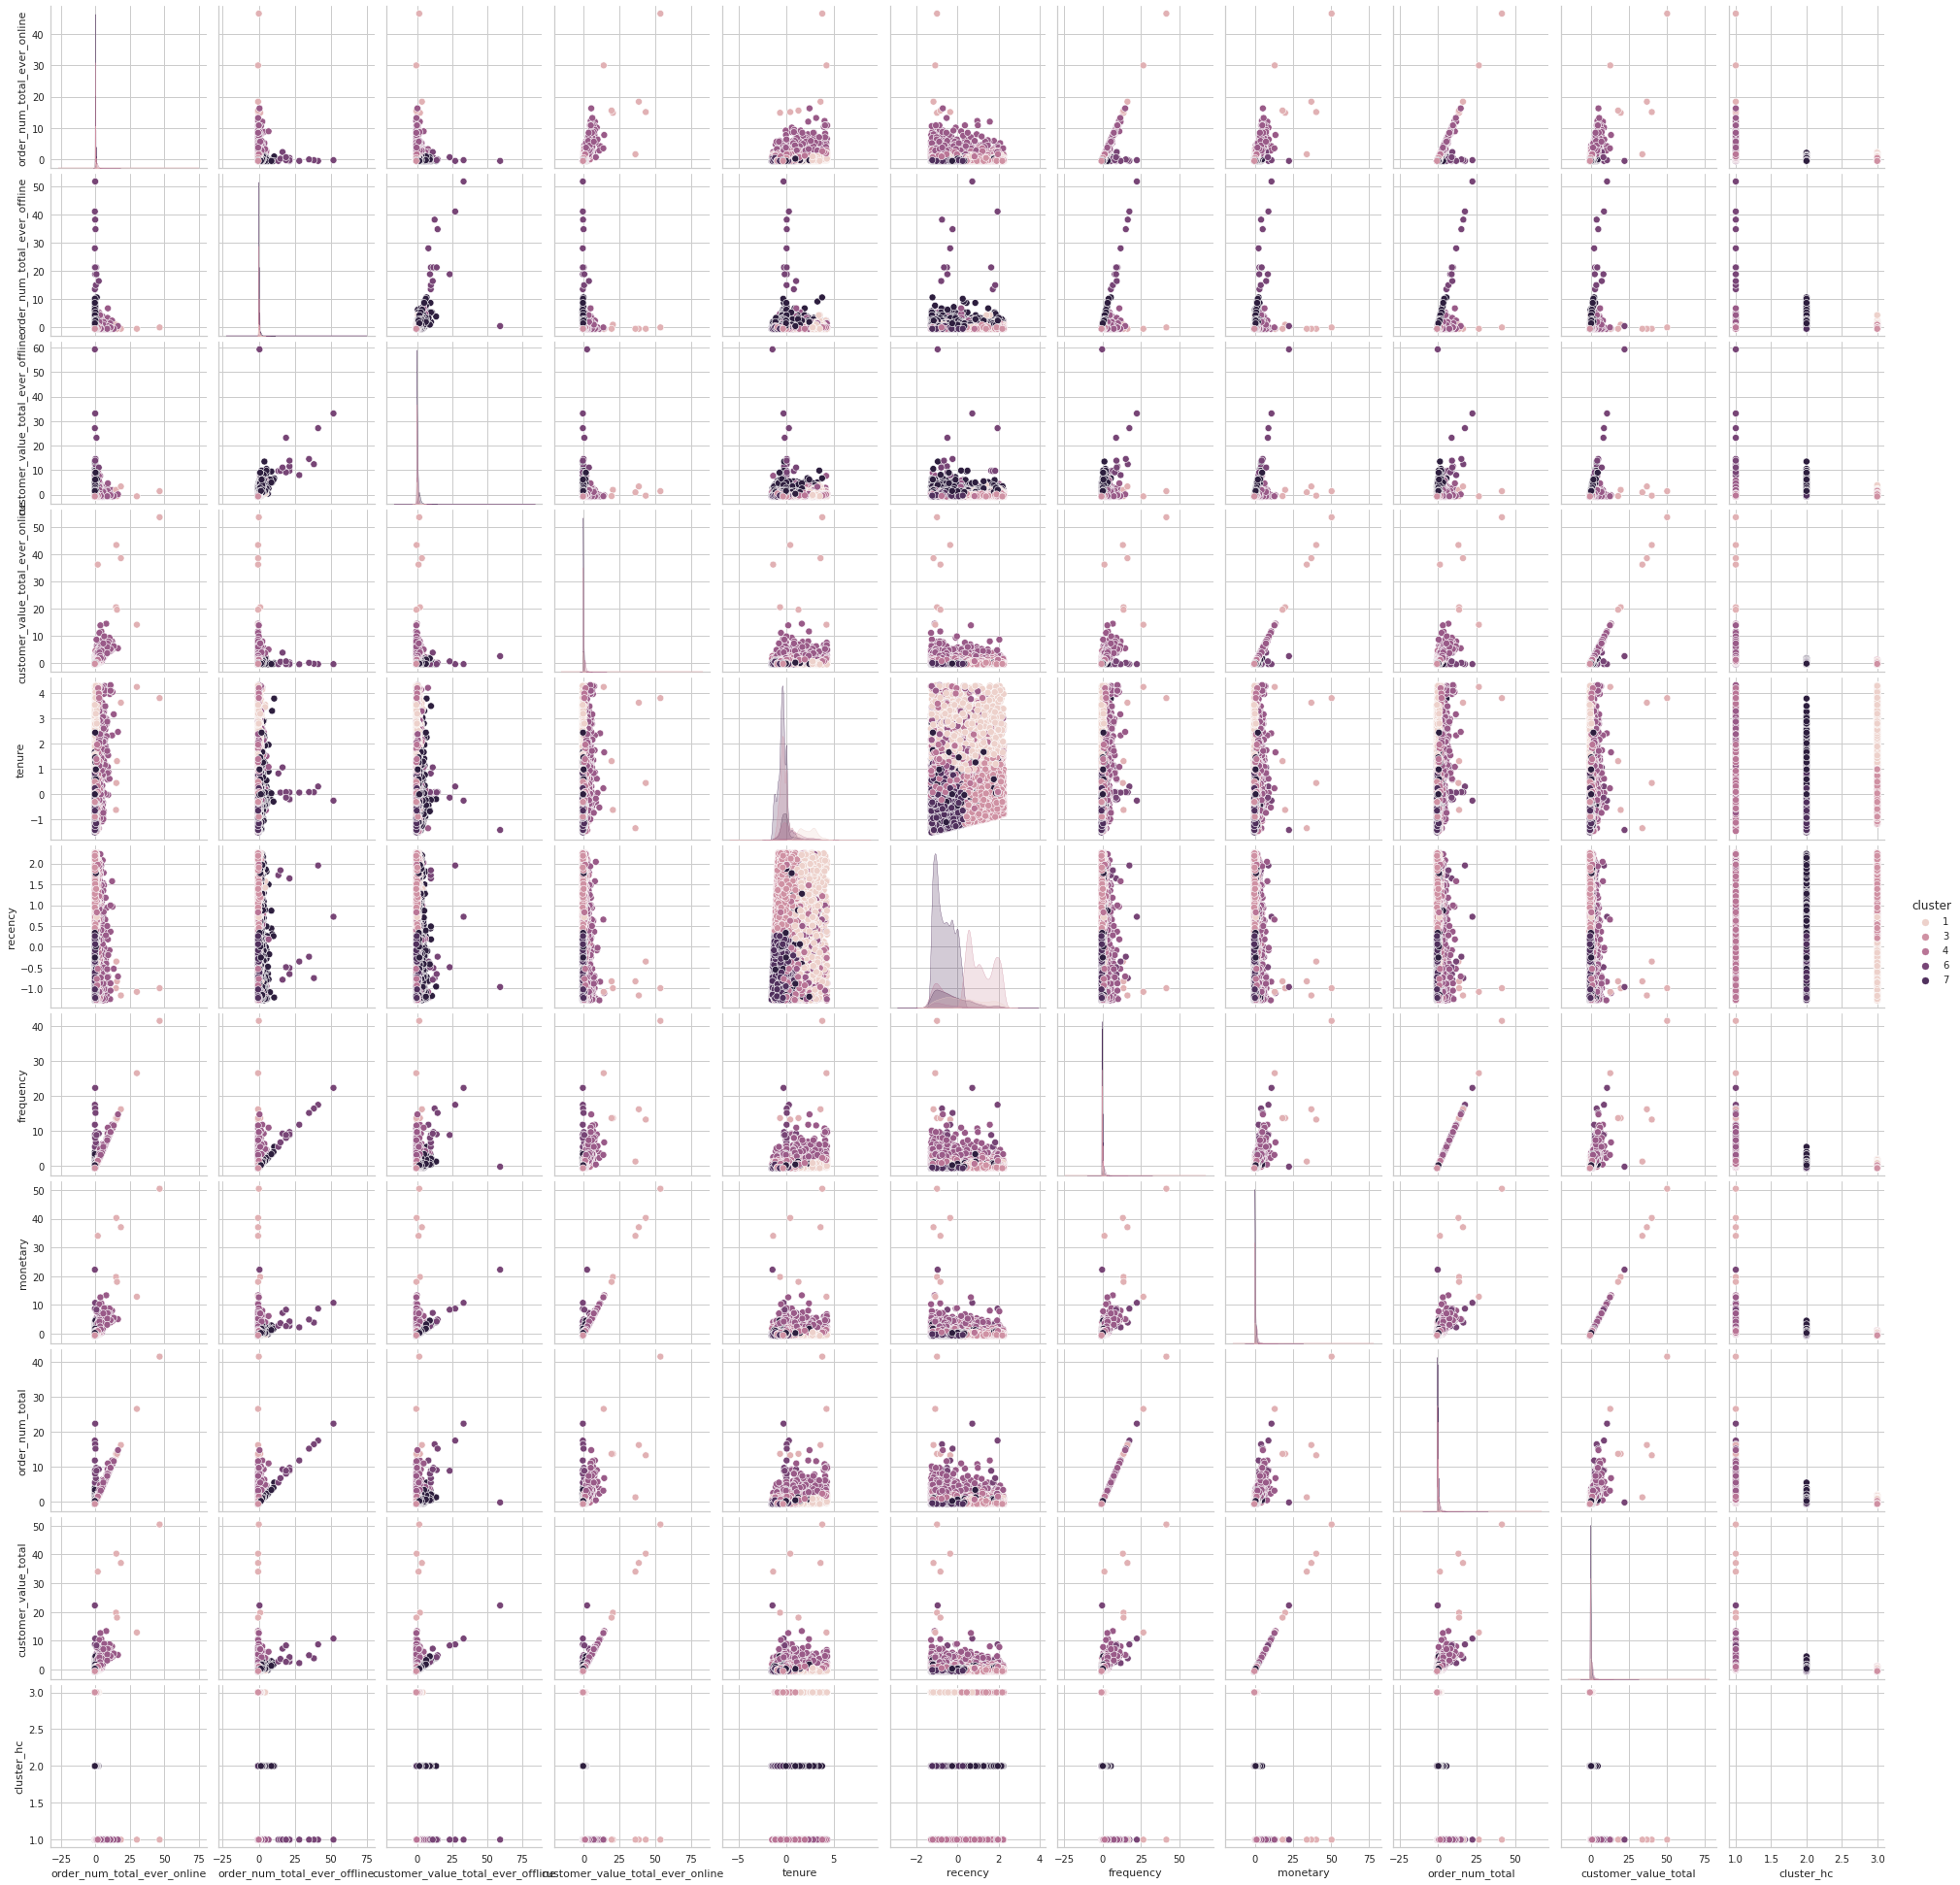

In [73]:
sns.pairplot(X, hue='cluster')
plt.show()

# 6. Customer Segmentation with DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that is based on the density of data points. It can be used for customer segmentation by finding groups of similar customers based on their characteristics or attributes.

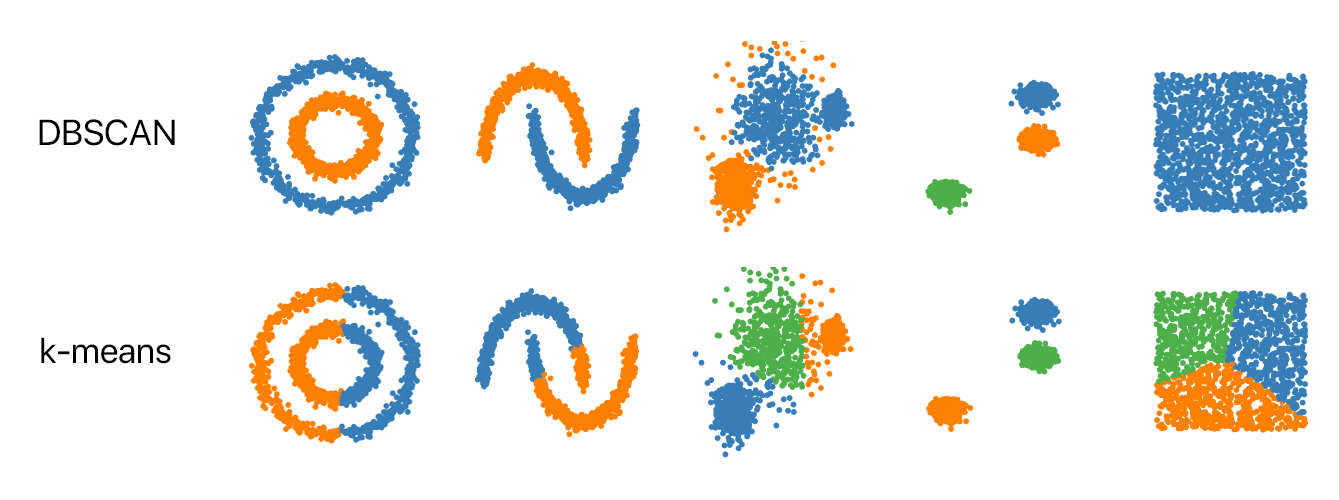

Use the DBSCAN class from scikit-learn to fit the model to your data. You'll need to specify two important parameters: eps and min_samples. eps is the maximum distance between two points in the same cluster, and min_samples is the minimum number of points required to form a cluster.

In [74]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=15)
clusters = dbscan.fit_predict(X)
print(clusters)
df['dbscan_cluster'] = clusters
df.head()

[ 0 -1  1 ...  0  2  1]


,master_id,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,tenure,recency,frequency,monetary,order_num_total,customer_value_total,order_channel_Desktop,order_channel_Ios App,order_channel_Mobile,last_order_channel_Desktop,last_order_channel_Ios App,last_order_channel_Mobile,last_order_channel_Offline,dbscan_cluster
0,cc294636-19f0-11eb-8d74-000d3a38a36f,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN],784,665,5.0,939.37,5.0,939.37,0,0,0,0,0,0,1,0
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2144,675,21.0,2013.55,21.0,2013.55,0,0,0,0,0,1,0,-1
2,69b69676-1a40-11ea-941b-000d3a38a36f,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]",1122,756,5.0,585.32,5.0,585.32,0,0,0,0,0,0,0,1
3,1854e56c-491f-11eb-806e-000d3a38a36f,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]",716,705,2.0,121.97,2.0,121.97,0,0,0,0,0,0,0,0
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR],1238,656,2.0,209.98,2.0,209.98,1,0,0,1,0,0,0,0


In [75]:
X['cluster_dbscan'] = clusters
X['cluster_dbscan'] = X['cluster_dbscan'] + 1
X.head()

,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,tenure,recency,frequency,monetary,order_num_total,customer_value_total,cluster,cluster_hc,cluster_dbscan
0,0.210422,-0.443039,-0.377854,0.362797,-1.122127,-0.382058,-0.005222,0.210107,-0.005222,0.210107,7,2,1
1,3.760263,0.041732,-0.311591,1.628981,1.476349,-0.285232,3.368463,1.409799,3.368463,1.409799,5,1,0
2,-0.026234,0.041732,-0.212097,-0.122477,-0.476329,0.499055,-0.005222,-0.185312,-0.005222,-0.185312,3,3,2
3,-0.499547,-0.443039,-0.709501,-0.498860,-1.252050,0.005244,-0.637788,-0.702802,-0.637788,-0.702802,7,2,1
4,-0.499547,-0.443039,-0.676337,-0.405164,-0.254694,-0.469201,-0.637788,-0.604508,-0.637788,-0.604508,7,2,1


In [76]:
X.groupby('cluster_dbscan').agg(['mean', 'median', 'count', 'std'])
X.groupby('cluster_dbscan').agg(['mean', 'median', 'count', 'std']).T

cluster_dbscan                                      0            1            2            3            4            5          6
order_num_total_ever_online       mean       1.520631    -0.279174    -0.316031    -0.230932     0.952549    -0.042942   0.470743
                                  median     1.157046    -0.499547    -0.499547    -0.262891     0.920390    -0.026234   0.447078
                                  count   2215.000000  8662.000000  5451.000000  1170.000000  1148.000000  1289.000000  10.000000
                                  std        2.209516     0.290105     0.269413     0.299050     0.444740     0.422982   0.074837
order_num_total_ever_offline      mean       0.754992    -0.186270    -0.198119     1.207669    -0.158848    -0.171883   1.205183
                                  median     0.041732    -0.443039    -0.443039     1.011275    -0.443039    -0.443039   1.011275
                                  count   2215.000000  8662.000000  5451.000000  1170.000000  1148.000000  1289.000000  10.000000
                                  std        2.482141     0.367810     0.373464     0.636923     0.370078     0.369356   0.250335
customer_value_total_ever_offline mean       0.905679    -0.197325    -0.236566     1.282636    -0.231577    -0.195745   1.015223
                                  median     0.354986    -0.311558    -0.344723     1.208895    -0.311558    -0.308275   0.973276
                                  count   2215.000000  8662.000000  5451.000000  1170.000000  1148.000000  1289.000000  10.000000
                                  std        2.321494     0.433822     0.428007     0.635297     0.392374     0.422935   0.245835
customer_value_total_ever_online  mean       1.279221    -0.223924    -0.259277    -0.169732     0.820975    -0.177084   0.384389
                                  median     0.837190    -0.307720    -0.337963    -0.252662     0.776145    -0.248783   0.436994
                                  count   2215.000000  8662.000000  5451.000000  1170.000000  1148.000000  1289.000000  10.000000
                                  std        2.441195     0.279932     0.263237     0.296552     0.413000     0.306362   0.201118
tenure                            mean       1.172615    -0.443003    -0.252269    -0.196921     0.091447     2.126002   0.006873
                                  median     1.050276    -0.426652    -0.321567    -0.216481    -0.012042     2.039989   0.030947
                                  count   2215.000000  8662.000000  5451.000000  1170.000000  1148.000000  1289.000000  10.000000
                                  std        1.431633     0.473695     0.459112     0.353115     0.648270     0.744142   0.216775
recency                           mean      -0.040585    -0.641047     1.168154    -0.393428    -0.530256     0.261475   0.704325
                                  median    -0.294915    -0.701582     1.070325    -0.527296    -0.720947     0.131118   0.649134
                                  count   2215.000000  8662.000000  5451.000000  1170.000000  1148.000000  1289.000000  10.000000
                                  std        1.015402     0.449079     0.614475     0.688279     0.644087     0.976823   0.263267
frequency                         mean       1.683238    -0.329758    -0.367750     0.319531     0.779608    -0.113022   0.943627
                                  median     1.259910    -0.426933    -0.426933     0.205633     0.838199    -0.216078   0.943627
                                  count   2215.000000  8662.000000  5451.000000  1170.000000  1148.000000  1289.000000  10.000000
                                  std        2.071974     0.288698     0.281455     0.341178     0.388826     0.373349   0.111131
monetary                          mean       1.494494    -0.274669    -0.320757     0.274108     0.685409    -0.230582   0.699313
                                  median     1.107146    -0.330373    -0.375019     0.245790     0.6

In [77]:
X["cluster_dbscan"].value_counts() 

1    8662
2    5451
0    2215
5    1289
3    1170
4    1148
6      10
Name: cluster_dbscan, dtype: int64

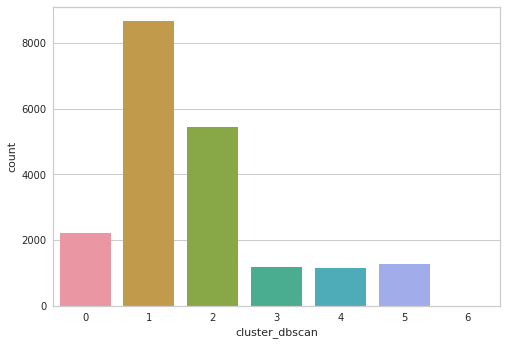

In [78]:
sns.countplot(x='cluster_dbscan', data=X)
plt.show()

# Conclusion

Segmenting customers into different groups using their characteristics and behaviors has always been an important topic. Customer segmentation can lead to better customer understanding and targeting, which in turn leads to more effective product tailoring and marketing strategies. Data mining methods are powerful techniques that can be used in customer segmentation to find customers with similar characteristics.

# References

1. https://miuul.com/makine-ogrenmesi
2. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
3. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html